# Two compartment model for SSD in neurons

In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.signal import resample
import matplotlib.pyplot as plt
import pandas as pd

from C_module_interface import neuron_gill_2c_sim
from plot_module import plot_ODE, plot_gillespie

In [2]:
# ode model of two compartment system
def neuron_model(t, z):
    s_w, s_m, a_w, a_m = z
    
    # birth reactions
    b_s_w = 2*MU + C_B*(NSS_S-s_w-s_m*DELTA) 
    b_s_m = 2*MU + C_B*(NSS_S-s_w-s_m*DELTA)
    b_a_w = 0
    b_a_m = 0
    
    # death reactions
    d_s_w = MU
    d_a_w = MU
    d_s_m = MU
    d_a_m = MU
    
    # transport reactions
    t_s_a_w = 2*GAMMA + C_T*(NSS_A-a_w-a_m*DELTA)
    t_s_a_m = 2*GAMMA + C_T*(NSS_A-a_w-a_m*DELTA)
    t_a_s_w = GAMMA
    t_a_s_m = GAMMA
    
    
    return [s_w*(b_s_w-d_s_w-t_s_a_w) + a_w*t_a_s_w, 
            s_m*(b_s_m-d_s_m-t_s_a_m) + a_m*t_a_s_m, 
            a_w*(b_a_w-d_a_w-t_a_s_w) + s_w*t_s_a_w, 
            a_m*(b_a_m-d_a_m-t_a_s_m) + s_m*t_s_a_m,]

### Parameters of the simulation

In [3]:
## BIOLOGICAL PARAMETERS ##
MU = 0.07 # death rate
GAMMA = 0.07 # transport rate
DELTA = 0.5 # mutant deficiency
C_B = 0.1 # birth adaptibility constant
C_T = 0.01 # transport adaptibility constant
NSS_S = 200 # soma population size
NSS_A = 200 # axon population size

## VARIABLE NAMES ##
VARS = ['Soma wt', 'Soma mt', 'Axon wt', 'Axon mt']
COMP = ['Soma', 'Axon']

## SIMULATION PARAMETERS ##
MAX_T = 5000
TIME_POINTS = np.linspace(0, MAX_T, 500)
start_state = np.array([190, 20, 190, 20], dtype = np.int64)

## Deterministic simulation

In [4]:
sol = integrate.solve_ivp(neuron_model, [0, MAX_T], start_state, t_eval=TIME_POINTS, 
                          method = 'LSODA' # eq system is stiff, needs a solver that can handle such cases
                         )

results = sol.y

Final counts of mt and wt in each compartment:
Soma wt	190.0	
Soma mt	20.0	
Axon wt	190.0	
Axon mt	20.0	

Final effective population sizes in each compartment:
Soma	200.0	
Axon	200.0	


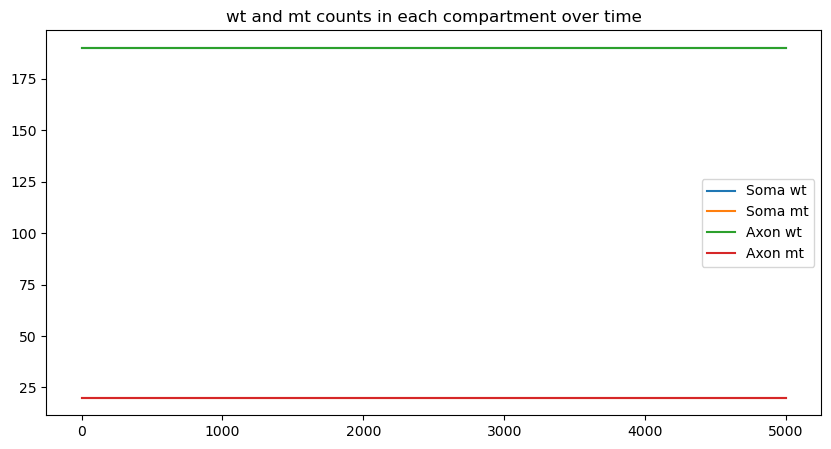

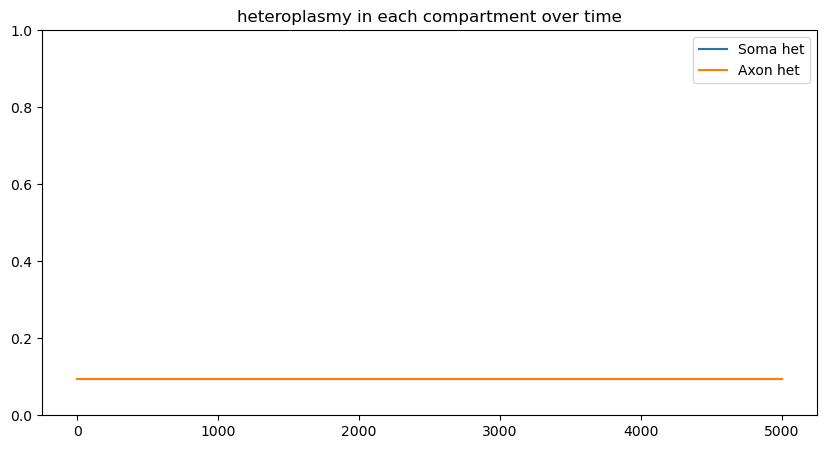

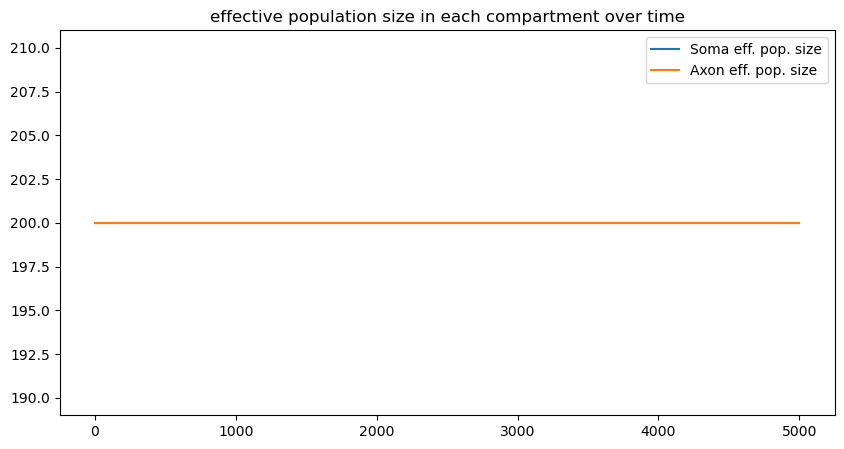

In [5]:
plot_ODE(results, TIME_POINTS, DELTA, VARS, COMP)

## Pooled results from Gillespie based simulation

In [6]:
REPLICATES = 1000
replicate_results = np.zeros((REPLICATES, len(VARS), TIME_POINTS.size), dtype = np.int64)

print('simulating...')
for i in range(REPLICATES):
    replicate_results[i, :, :] = np.swapaxes(neuron_gill_2c_sim(MU, GAMMA, DELTA, C_B, C_T, NSS_S, NSS_A, TIME_POINTS, start_state), 0, 1)
    print(f"{round(((i+1)/REPLICATES)*100, 2)}% completed  ", end = "\r")

simulating...


Final mean counts of mt and wt in each compartment:
Soma wt	176.538	
Soma mt	46.934	
Axon wt	176.63	
Axon mt	46.671	

Final mean heteroplasmy in each compartment:
Soma	0.124	
Axon	0.1237	

Final mean effective population sizes in each compartment:
Soma	200.005	
Axon	199.9655	


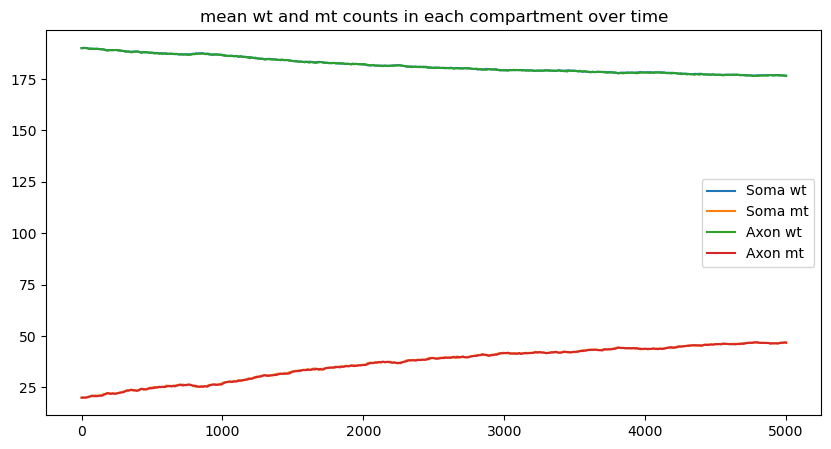

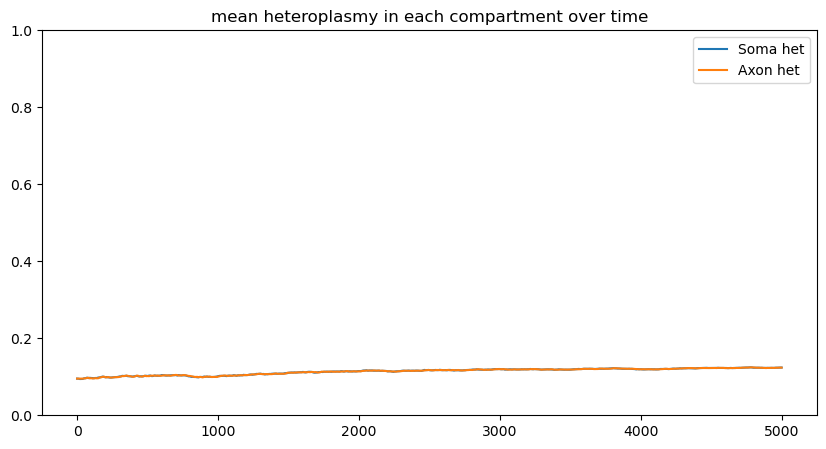

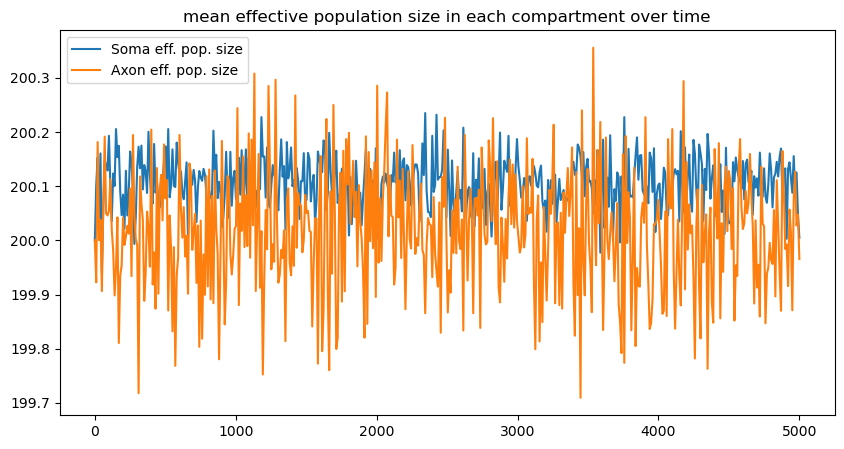

In [7]:
plot_gillespie(replicate_results, TIME_POINTS, DELTA, VARS, COMP)